# Exploring the NIFTY 50 index under different SMA regimes

Markets tend to be manic depressive, going from excessive optimism to excessive pessimism. The distribution of returns tend to be different based on the "regime." A simple way to demarcate these regimes is by using an SMA (Simple Moving Average) to bucket returns into binary groups. Here, we explore how returns are distributed in these buckets.

In [1]:
library(tidyverse)
library(ggthemes)
library(odbc)
library(RPostgres)
library(plutoR)
library(quantmod)
library(PerformanceAnalytics)
library(reshape2)
library(ggrepel)
library(lubridate)

options("scipen"=999)
options(stringsAsFactors = FALSE)
options(repr.plot.width=16, repr.plot.height=8)

source("config.R")
source("goofy/plot.common.R")
source("goofy/misc.common.R")

#initialize
indices<-Indices()

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: xts
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 

Attaching package: ‘xts’

The following objects are masked from ‘package:dplyr’:

    first, last

Loading required package: TTR
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Version 0.4-0 included new data defaults. See ?getSymbols.

Attaching package: ‘PerformanceAnalytics’

The following object is masked from

In [2]:
indexName <- 'NIFTY 50'
smaLb <- 50 #number of days
px <- indices$NseTimeSeries() %>%
    filter(NAME == indexName) %>%
    select(TIME_STAMP, CLOSE) %>%
    collect()

#if we break by years, make sure that they have at least 200 days
numDays <- px %>%
    group_by(Y = year(TIME_STAMP)) %>%
    summarize(N = n())

yrs <- numDays %>%
    filter(N >= 200) %>%
    pull(Y)

In [3]:
pXts <- xts(px$CLOSE, px$TIME_STAMP)
names(pXts) <- c('INDEX')
pXts$SMA <- SMA(pXts[,1], smaLb)
pXts$D_RET <- dailyReturn(pXts$INDEX)
pXts$D_RET_PCT <- pXts$D_RET * 100

pXts <- na.omit(pXts)

In [4]:
statByYear <- data.frame(Y = 0, N_ABOVE = 0, N_BELOW = 0, AVG_ABOVE = 0.0, AVG_BELOW = 0.0, SD_ABOVE = 0.0, SD_BELOW = 0.0)

for(yr in yrs){
    yrStr <- toString(yr)
    numAbove <- as.numeric(sum(ifelse(pXts[yrStr,'INDEX'] > pXts[yrStr,'SMA'], 1, 0)))
    numBelow <- as.numeric(sum(ifelse(pXts[yrStr,'INDEX'] <= pXts[yrStr,'SMA'], 1, 0)))
    
    avgAbove <- as.numeric(mean(pXts[pXts[yrStr,'INDEX'] > pXts[yrStr,'SMA'], 'D_RET_PCT']))
    avgBelow <- as.numeric(mean(pXts[pXts[yrStr,'INDEX'] <= pXts[yrStr,'SMA'], 'D_RET_PCT']))
    
    sdAbove <- as.numeric(sd(pXts[pXts[yrStr,'INDEX'] > pXts[yrStr,'SMA'], 'D_RET_PCT']))
    sdBelow <- as.numeric(sd(pXts[pXts[yrStr,'INDEX'] <= pXts[yrStr,'SMA'], 'D_RET_PCT']))
    
    statByYear <- rbind(statByYear, c(yr, numAbove, numBelow, avgAbove, avgBelow, sdAbove, sdBelow))
}

statByYear <- statByYear[-1,]
print(statByYear)

      Y N_ABOVE N_BELOW    AVG_ABOVE   AVG_BELOW SD_ABOVE SD_BELOW
2  1991     168      38  0.248315442 -0.50584419 1.984067 3.157296
3  1993     130      83  0.195580299  0.03712470 1.945452 2.648462
4  1994     130     100  0.026797011  0.26752747 2.356983 1.925064
5  1995      70     166  0.234640851  0.06931731 1.473594 2.387737
6  1996     110     140  0.031809707  0.20579036 1.985158 2.216717
7  1997     142     102  0.031039571  0.24881758 2.432092 1.626814
8  1998      89     161  0.093603673  0.14893783 2.510777 1.870015
9  1999     213      41  0.143259250  0.11700264 2.175789 1.685422
10 2000     112     138 -0.220429727  0.41302788 2.359843 1.855135
11 2001      93     155 -0.196457507  0.33720608 2.504139 1.834925
12 2002      96     155 -0.149815610  0.30274374 2.495766 1.820820
13 2003     173      81  0.197320574  0.01450456 1.996693 2.317592
14 2004     170      84  0.174504715  0.06720865 2.179933 1.943528
15 2005     187      64  0.022153154  0.44375532 2.029159 2.32

The NIFTY got hammered by the GFC in 2008, only to be reflated in 2009. The years prior to do that was a different "regime." Not sure if they can be used in back-tests any more. Let's look at the data from 2010 onwards.

In [5]:
stat200 <- rollapply(pXts["2010/",], 200, function(X){
    numAbove <- as.numeric(sum(ifelse(X[,'INDEX'] > X[,'SMA'], 1, 0)))
    numBelow <- as.numeric(sum(ifelse(X[,'INDEX'] <= X[,'SMA'], 1, 0)))
    
    avgAbove <- as.numeric(mean(X[X[,'INDEX'] > X[,'SMA'], 'D_RET_PCT']))
    avgBelow <- as.numeric(mean(X[X[,'INDEX'] <= X[,'SMA'], 'D_RET_PCT']))
    
    sdAbove <- as.numeric(sd(X[X[,'INDEX'] > X[,'SMA'], 'D_RET_PCT']))
    sdBelow <- as.numeric(sd(X[X[,'INDEX'] <= X[,'SMA'], 'D_RET_PCT']))
    
    xts(matrix(c(numAbove, numBelow, avgAbove, avgBelow, sdAbove, sdBelow), nrow=1), as.Date(last(index(X))))
}, by.column = FALSE)

stat200 <- na.omit(stat200)
names(stat200) <- c('N_ABOVE', 'N_BELOW', 'AVG_ABOVE', 'AVG_BELOW', 'SD_ABOVE', 'SD_BELOW')

print("stat200: HEAD")
print(head(stat200))

print("stat200: TAIL")
print(tail(stat200))

[1] "stat200: HEAD"
           N_ABOVE N_BELOW AVG_ABOVE AVG_BELOW  SD_ABOVE SD_BELOW
2010-10-18     145      55 0.1649784 -0.133722 0.7921170 1.417652
2010-10-19     145      55 0.1553259 -0.133722 0.7953137 1.417652
2010-10-20     145      55 0.1441303 -0.133722 0.7965596 1.417652
2010-10-21     145      55 0.1573859 -0.133722 0.8112400 1.417652
2010-10-22     145      55 0.1558207 -0.133722 0.8124517 1.417652
2010-10-25     145      55 0.1627444 -0.133722 0.8124005 1.417652
[1] "stat200: TAIL"
           N_ABOVE N_BELOW AVG_ABOVE  AVG_BELOW  SD_ABOVE  SD_BELOW
2019-07-22     129      71 0.1371629 -0.1914631 0.7857272 1.0386160
2019-07-23     129      71 0.1371629 -0.1873007 0.7857272 1.0382423
2019-07-24     129      71 0.1371629 -0.2047590 0.7857272 1.0333102
2019-07-25     129      71 0.1371629 -0.1879539 0.7857272 1.0238625
2019-07-26     129      71 0.1371629 -0.1503341 0.7857272 0.9904994
2019-07-29     129      71 0.1371629 -0.1246250 0.7857272 0.9469466


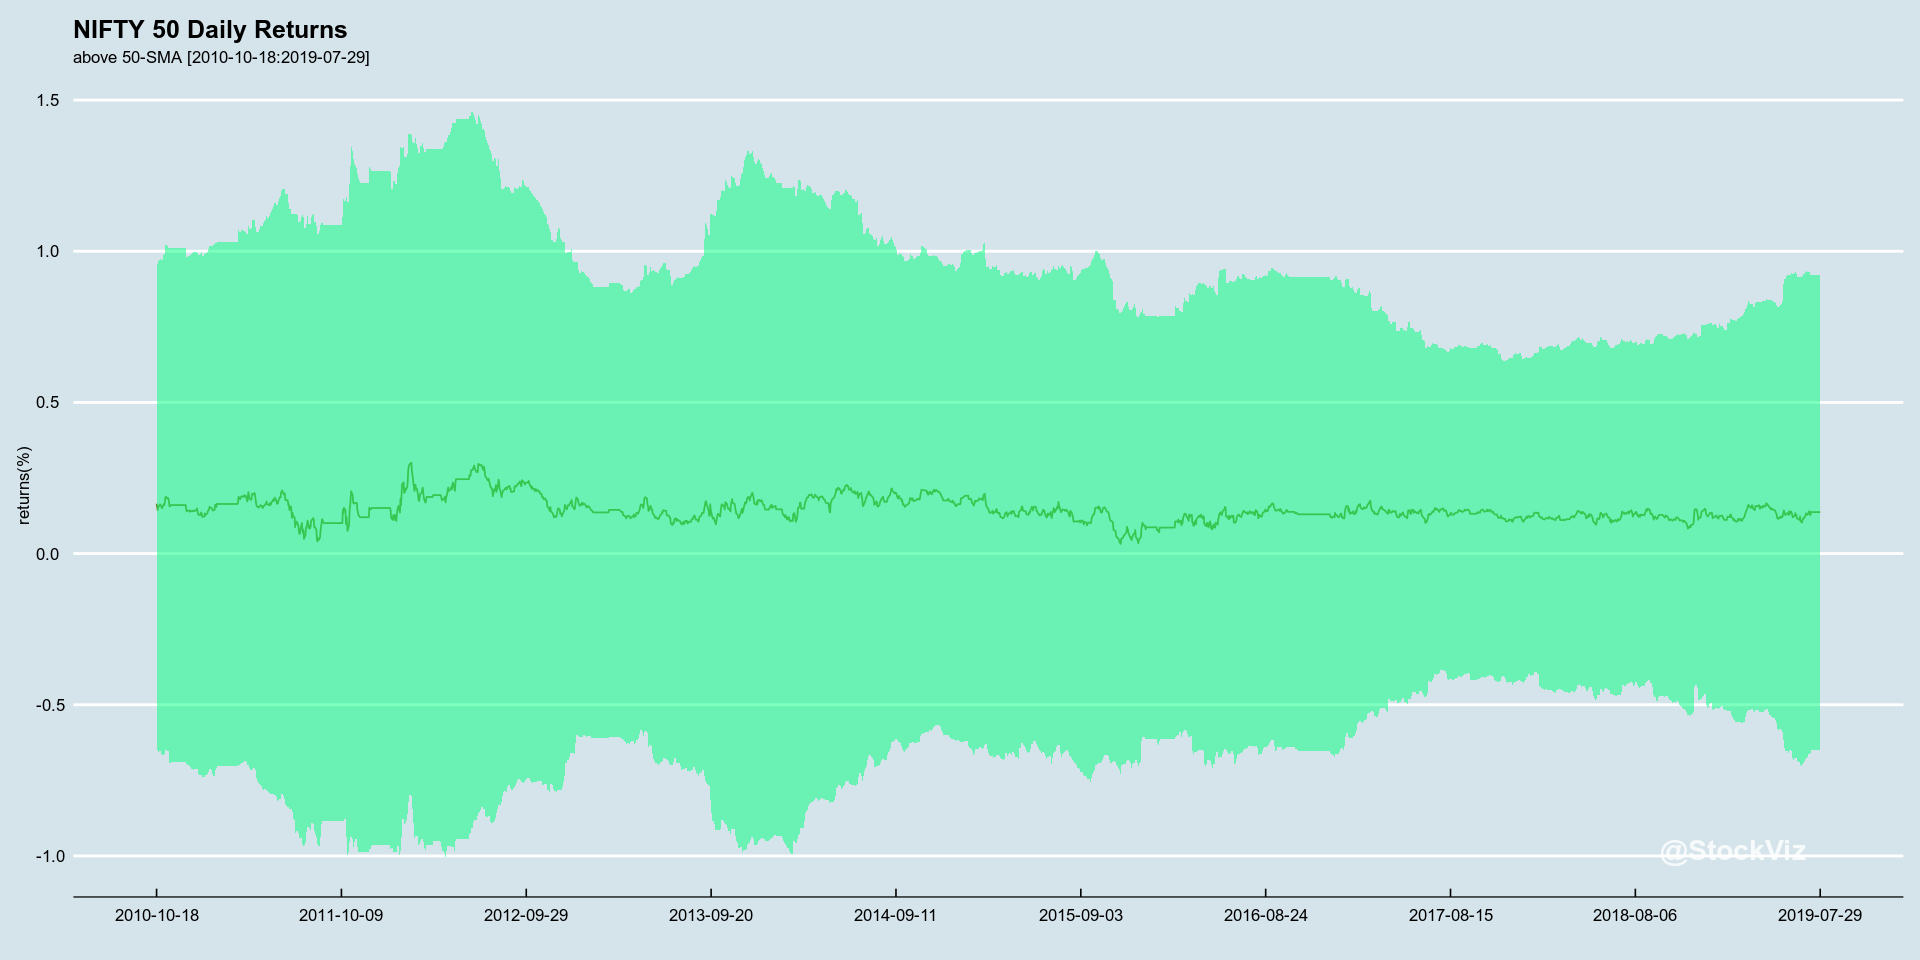

In [6]:
stat200Df <- data.frame(stat200)
stat200Df$T <- as.Date(index(stat200))

plotStart <- first(index(stat200))
plotEnd <- last(index(stat200))
xAxisTicks<-seq(plotStart, plotEnd, length.out=10)

ggplot(stat200Df, aes(x=T)) +
    theme_economist() +
    geom_line(aes(y=AVG_ABOVE), color='olivedrab') +
    geom_ribbon(aes(ymin = AVG_ABOVE - SD_ABOVE, ymax = AVG_ABOVE + SD_ABOVE), fill='springgreen', alpha=0.5) +
    scale_x_date(breaks = xAxisTicks) +
    labs(x = "", y="returns(%)", fill="", color="", 
         title = sprintf("%s Daily Returns", indexName, smaLb),
         subtitle = sprintf("above %d-SMA [%s:%s]", smaLb, plotStart, plotEnd)) +
    annotate("text", x=plotEnd, y=min(stat200Df$AVG_ABOVE - stat200Df$SD_ABOVE), label = "@StockViz", 
             hjust=1.1, vjust=0, col="white", cex=6, fontface = "bold", alpha = 0.8)


This notebook was created using [pluto](http://pluto.studio). Learn more [here](https://github.com/shyams80/pluto)